# Modeling Building<br/>*Stacking and VotingClassifiers*

## Goals
1. Describe Ensembles
2. Describe the Stacking Algorithm
3. Custom Code a Stacking Classifier
4. Use Stacking Classifier and Analyze Results
5. Use VotingClassifier and Analyze Results
6. Tune Base Learners and Analysze Results
7. Simplify and present interpretable decision tree

## Ensemble Description
An *ensemble* makes use of multiple models to improve predictions.  Each model in the ensemble is called a *base learner* (or base estimator).  The predictions from the base learners are fed into another model, the *meta learner*, to create the final prediction.

An ensemble of base learners is analogous to a group of experts.  Each person in the group can vote on a recommendation, the votes can be tallied up, and the "winner" is the best recommendation.  In this example, each expert is a *base learner* and "tallying up the votes" is the *meta learner* used to combine the recommendations.

For an ensemble to work well:
* each expert should be better at predicting than random chance
* the experts should not always agree with each other

Some of Scikit Learn's estimators are ensembles that consist of multiple base learners which are trained internally, the results combined, and a prediction is made.  See: [Scikit Learn Ensembles](https://scikit-learn.org/stable/modules/ensemble.html)

There are many types of ensembles.  The type discussed here is called a Stack.

In this notebook, a custom Stack estimator will be coded from scratch and used on the Titanic data set.

## Prepare Data for Modeling
Same as in previous notebooks.

### Common Imports and Notebook Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
%matplotlib inline
sns.set() # enable seaborn style

import titanic_helper_code as tt

In [2]:
# Version Information
import sys
print('python:     ', sys.version)
print('numpy:      ', np.__version__)
print('pandas:     ', pd.__version__)
import matplotlib
print('matplotlib: ', matplotlib.__version__)
print('seaborn:    ', sns.__version__)
print('sklearn:    ', sk.__version__)
!lsb_release -d

python:      3.7.3 (default, Mar 27 2019, 22:11:17) 
[GCC 7.3.0]
numpy:       1.16.4
pandas:      0.24.2
matplotlib:  3.1.0
seaborn:     0.9.0
sklearn:     0.21.2
Description:	Ubuntu 18.04.2 LTS


In [3]:
# Scikit Learn imports
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression, BayesianRidge
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, log_loss
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.impute import SimpleImputer
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.compose import ColumnTransformer

from xgboost import XGBClassifier

In [4]:
# explictly enable and import new iterative imputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

## Performance of Individual Models
Initially, the base learners will use default values for all hyperparameters.

As per previous discussions, unless otherwise noted, these notebooks use:  
* Model Selection: 10x 2-Fold Cross Validation 
  * or 5x 2-Fold CV for nested operations
* Model Evaluation: 10x 10-Fold Cross Validation  

In [5]:
# get the X predictor matrix and the y target vector
X, y = tt.get_Xy_v6()

# instantiate a few estimators using Scikit Learn defaults
lr  = LogisticRegression(solver='liblinear')
knn = KNeighborsClassifier()
xgb = XGBClassifier(objective='binary:logistic')
svm = SVC(gamma='auto', probability=True)
nn  = MLPClassifier(max_iter=2000, random_state=101)

# apply the ColumnTransform logic used in previous notebooks
cols, ct = tt.get_ct_v5()
lr_pipe = Pipeline([('ct', ct), ('lr', lr)])
knn_pipe = Pipeline([('ct', ct), ('knn', knn)])
# xgb seems to work better without the data preprocessing
svm_pipe = Pipeline([('ct', ct), ('svm', svm)])
nn_pipe = Pipeline([('ct', ct), ('nn', nn)])

base_learners = [lr_pipe, knn_pipe, xgb, svm_pipe, nn_pipe]

In [6]:
# Cross Validation Generators used in this Notebook
cv_select = RepeatedStratifiedKFold(n_splits=2, n_repeats=10, 
                                    random_state=108)
cv_select_quick = RepeatedStratifiedKFold(n_splits=2, n_repeats=5, 
                                          random_state=108)
cv_predict = StratifiedKFold(n_splits=10, random_state=1001)

In [11]:
# Evaluate the Accuracy of each base learner
for base_learner in base_learners:
    if hasattr(base_learner, 'steps'):
        name = base_learner.steps[1][0].upper()
    else:
        name = base_learner.__class__.__name__

    scores  = cross_val_score(base_learner,  X, y, scoring='accuracy', 
                              cv=cv_select)
    print(f'{name:13} Score: {scores.mean():.3f} +/- {scores.std():.3f}')

LR            Score: 0.830 +/- 0.013
KNN           Score: 0.806 +/- 0.015
XGBClassifier Score: 0.823 +/- 0.013
SVM           Score: 0.831 +/- 0.013
NN            Score: 0.816 +/- 0.016


### K-Fold cross_val_score and K-Fold cross_val_predict  

**K-Fold cross_val_score**  
Uses cross validation to predict on each of K test folds, scores that prediction, and keep track of each score.

cross_val_score will call the estimator's predict or predict_proba method, depending upon the scoring object used.

**K-Fold cross_val_predict**  
Uses cross validation to predict on each of K test folds and returns all the predictions.

These predictions can be scored in any way, including the same way they are scored with cross_val_score.

### Use cross_val_predict to get same results as from cross_val_score
This is helpful in understanding these functions work.

In [8]:
# Part 1: Accuracy -- cross_val_score uses predict
acc_scores = cross_val_score(lr_pipe, X, y, scoring='accuracy', cv=cv_predict)

acc_scores2 = []
predictions = cross_val_predict(lr_pipe, X, y, cv=cv_predict, method='predict')
for train_index, test_index in cv_predict.split(X, y):
    fold_score = accuracy_score(y.iloc[test_index], predictions[test_index])
    acc_scores2.append(fold_score)

# verify results are the same
print((acc_scores == acc_scores2).all())

True


In [9]:
# Part 2: Log Loss -- cross_val_score uses predict_proba
logloss_scores = cross_val_score(lr_pipe, X, y, 
                                 scoring='neg_log_loss', cv=cv_predict)

logloss_scores2 = []
predictions = cross_val_predict(lr_pipe, X, y, cv=cv_predict, method='predict_proba')
for train_index, test_index in cv_predict.split(X, y):
    fold_score = -log_loss(y.iloc[test_index], predictions[test_index])
    logloss_scores2.append(fold_score)

# verify results are the same
print((logloss_scores == logloss_scores2).all())

True


## Stacking

**Algorithm**
1. fit(X_train, y_train)
   * Create meta-features using base learners
   * Fit meta learner on these meta-features
   * Fit base learners (for use in next step)
2. predict(X_test)
   * Create meta-features using fitted base learners
   * Create predictions using fitted meta-learner on these meta-features

There is an important subtlety to the above, described next.

### Stacking Algorithm Subtly  
In general, the process of building a model should not have a step which both fits and predicts, on exactly the same data.  In step 1 above, for creating the meta level features, the base learners could fit the training data, and then predict on that same training data to create the meta level features, but this would be overfitting.

Instead the meta level features in step 1 above should use "cross validated predictions".  Here is a quote from Scikit Learn on [cross_val_predict](https://scikit-learn.org/stable/modules/cross_validation.html#obtaining-predictions-by-cross-validation)
> The function cross_val_predict is appropriate for:  
* Visualization of predictions obtained from different models.  
* Model blending: When predictions of one supervised estimator are used to train another estimator in ensemble methods. 

An good alternative description of the Stacking algorithm, which also describes the use of cross validated predictions for meta level features, can be found at: [Super Learner Algorithm](https://h2o-release.s3.amazonaws.com/h2o/rel-ueno/2/docs-website/h2o-docs/data-science/stacked-ensembles.html#super-learner-algorithm)

### On Building a Custom Stacking Estimator
There are several good libraries available for stacking such as [mlxtend](http://rasbt.github.io/mlxtend/) and [mlens](https://mlens.readthedocs.io/en/0.1.x/).

As of May 2019, there was an issue using Scikit Learn's new ColumnTransformer with mlxtend.  Previously developers got around the use of ColumnTransformer by using [sklearn-pandas](https://github.com/scikit-learn-contrib/sklearn-pandas), but ColumnTransformer is native to Scikit Learn and works well, so it's nice to be able to use it.

A custom Stacking classifier will be created from scratch.  This classifier will work with ColumnTransformer and with cross_val_score.  Writing such as classifier is easy.  What is not easy is to make this classifier work with GridSearchCV, parallelize the operations, properly report misuse by end-users, etc.  But there is no need for that here.

A good approach to software development is to first create a simple working example, and then abstract that logic into an object or function.  A key to making this process simple, is to take care in choosing variable and method names which accurately convey to any developer, what each step is doing.

### Stacking Example

Above algorithm in six steps:
1. Create Train/Test Split
2. Create Training Meta-Features using Base Learners and cross_val_predict on training data
3. Fit Meta-Learner on Training Meta-Features
4. Fit Base learners on training data
5. Create Test Meta-Features using fitted base learners on test data
6. Predict/Evaluate Fitted Meta-Learner on Test Meta-Features

#### 1. Create Train/Test split
Key Points:  
* Train/Test split used for illustration.  Cross Validation is better for this data set.

In [10]:
# Start with train/test split, later use cross validation
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.333, random_state=1001)

#### 2. Create Training Meta-Features Using Base Learners and cross_val_predict
Key points:
* use cross_val_predict on training data to avoid overfitting
* for classification, use predict_proba to provide more information to the meta-learner

In [11]:
# predict_proba outputs [probability NotSurvived, probability Survived]
# so select the 2nd column only
p1_train = cross_val_predict(lr_pipe, X_train, y_train, cv=cv_predict, 
                             method='predict_proba')[:, 1]
p2_train = cross_val_predict(svm_pipe, X_train, y_train, cv=cv_predict, 
                             method='predict_proba')[:, 1]

# combine features
meta_train = np.column_stack((p1_train, p2_train))

#### 3. Fit Meta Learner on Training Meta Features

In [12]:
meta_learner = SVC(gamma='auto')
meta_learner.fit(meta_train, y_train);

#### 4. Fit Base Learners on Training Data

In [13]:
# fit base learners on all of train
lr_pipe.fit(X_train, y_train)
svm_pipe.fit(X_train, y_train);

#### 5. Create Test Meta Features using Fitted Base Learners on Test Data

In [14]:
# predict probability of survived
p1_test= lr_pipe.predict_proba(X_test)[:, 1]
p2_test = svm_pipe.predict_proba(X_test)[:, 1]

# combine features
meta_test = np.column_stack((p1_test, p2_test))

#### 6. Predict/Evaluate Meta Learning on Test Meta Features

In [15]:
meta_pred = meta_learner.predict(meta_test)
score = accuracy_score(y_test, meta_pred)
np.round(score, 3)

0.832

#### Above Score May Have Strong Bias and Variance
The above score was computed from a single train/test split.  The Titanic data set is small, so both the train and test splits are small.  A small train split my cause a large score bias.  A small test split may cause a large score variance.  Cross Validation should be used instead.

Below a custom Stacking estimator will be created to encapsulate the algorithm for use with cross_val_score.

## Create Custom Stacking Classifier
The following classifier contains the minimum code necessary to illustrate the concepts of Stacking and of creating a Custom Classifier.

In particular, this Stacking Classifier:
* only works with a binary target variable
* supports any number of base learners (having predict_proba)
* supports any meta learner
* supports cross_val_score, but does not support GridSearchCV
* does not support parallelization 
* does not provide error handling

See: [Rolling your own estimator](https://scikit-learn.org/stable/developers/contributing.html#rolling-your-own-estimator)

In [16]:
from sklearn.base import BaseEstimator, ClassifierMixin
class StackedClassifier(BaseEstimator, ClassifierMixin):
    '''Minimal Stacking Classifier
    
       Uses predict_proba for level 1 meta features.
    '''

    def __init__(self, base_learners, meta_learner, cv):
        self.base_learners = base_learners
        self.meta_learner = meta_learner
        self.cv = cv

    def fit(self, X, y):      
        
        # Create Training Features
        train_cols = []
        for base_learner in self.base_learners:
            tmp = cross_val_predict(base_learner, X, y, cv=self.cv,
                                    method='predict_proba')[:, 1]
            train_cols.append(tmp)
        X_meta_train = np.column_stack(train_cols)
        
        # fit meta learner on train
        self.meta_learner.fit(X_meta_train, y)
        
        # fit the base learners on the entire training data
        for base_learner in self.base_learners:
            base_learner.fit(X, y)

        # Return the classifier
        return self

    def predict(self, X):
        
        # Create Test Features
        test_cols = []
        for base_learner in self.base_learners:
            tmp = base_learner.predict_proba(X)[:, 1]
            test_cols.append(tmp)
        X_meta_test = np.column_stack(test_cols)
        
        predictions = self.meta_learner.predict(X_meta_test)

        return predictions

### Use Custom Estimator with cross_val_score
Per the above, the individual models scored:  
LR            Score: 0.830 +/- 0.013  
KNN           Score: 0.806 +/- 0.015  
XGBClassifier Score: 0.823 +/- 0.013  
SVM           Score: 0.831 +/- 0.013  
NN            Score: 0.816 +/- 0.016  

Ideally we would like to see a score better than .830.

In [17]:
# Prepare the individual base learners

# Instantiate Estimators
lr  = LogisticRegression(solver='liblinear')
knn = KNeighborsClassifier()
xgb = XGBClassifier(objective='binary:logistic')
svm = SVC(gamma='auto', probability=True)
nn  = MLPClassifier(max_iter=2000, random_state=101)

# Get ColumnTransform Preprocessing Object
cols, ct = tt.get_ct_v5()

# Prepend Preprocessing to create Pipeline
lr_pipe = Pipeline([('ct', ct), ('lr', lr)])
knn_pipe = Pipeline([('ct', ct), ('knn', knn)])
# xgb seems to work better without the data preprocessing
svm_pipe = Pipeline([('ct', ct), ('svm', svm)])
nn_pipe = Pipeline([('ct', ct), ('nn', nn)])

#### Experiment with Various Stacked Classifiers

In [23]:
# LR, KNN with SVM meta learner
base_learners = [lr_pipe, knn_pipe]
meta_learner = SVC(gamma='auto')
sc = StackedClassifier(base_learners, meta_learner, cv_predict)
scores = cross_val_score(sc, X, y, cv=cv_select)
tt.print_scores(scores)

20 Scores  min:0.809 max:0.850
CV Mean Score: 0.826 +/- 0.013


In [19]:
# LR, SVM with SVM meta learner
base_learners = [lr_pipe, svm_pipe]
meta_learner = SVC(gamma='auto')
sc = StackedClassifier(base_learners, meta_learner, cv_predict)
scores = cross_val_score(sc, X, y, cv=cv_select)
tt.print_scores(scores)

20 Scores  min:0.812 max:0.857
CV Mean Score: 0.832 +/- 0.014


In [20]:
# LR, SVM, XGB with SVM meta learner
base_learners = [lr_pipe, svm_pipe, xgb]
meta_learner = SVC(gamma='auto')
sc = StackedClassifier(base_learners, meta_learner, cv_predict)
scores = cross_val_score(sc, X, y, cv=cv_select)
tt.print_scores(scores)

20 Scores  min:0.811 max:0.854
CV Mean Score: 0.832 +/- 0.013


In [21]:
# LR, SVM, KNN, XGB with SVM meta learner
base_learners = [lr_pipe, svm_pipe, knn_pipe, xgb]
meta_learner = SVC(gamma='auto')
sc = StackedClassifier(base_learners, meta_learner, cv_predict)
scores = cross_val_score(sc, X, y, cv=cv_select)
tt.print_scores(scores)

20 Scores  min:0.809 max:0.852
CV Mean Score: 0.833 +/- 0.013


In [22]:
# LR, SVM, KNN, XGB, NN with SVM meta learner
base_learners = [lr_pipe, svm_pipe, knn_pipe, xgb, nn_pipe]
meta_learner = SVC(gamma='auto')
sc = StackedClassifier(base_learners, meta_learner, cv_predict)
scores = cross_val_score(sc, X, y, cv=cv_select)
tt.print_scores(scores)

20 Scores  min:0.807 max:0.854
CV Mean Score: 0.830 +/- 0.014


### Initial Stacking Classifier Results Analysis
More experiments were tried than are presented above, but the above results are illustrative of what happened.

There was little or no improvement, on the Titanic data set, using the unoptimized base learners and unoptimized meta learners when combined into a Stack.

## Voting Classifier
The [voting classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html) is similar to the stacked classifier, except that the meta learner makes use the sum of the probabilities (voting=soft) or the sum of the class labels (voting=hard) for each of its base learners.

From the documentation:
> voting : str, {‘hard’, ‘soft’} (default=’hard’)
If ‘hard’, uses predicted class labels for majority rule voting. Else if ‘soft’, predicts the class label based on the argmax of the sums of the predicted probabilities, which is recommended for an ensemble of well-calibrated classifiers.

A "well-calibrated classifier" is one in which the probabilities have been tuned to be more accurate.  This requires a hold-out set for the probability tuning and the Titanic data set is too small for an additional hold-out set.

ToDo: Nevertheless, it is instructive to look at the a couple of calibration curves and understand what happens when an estimator is tuned for accuracy vs being tuned for log loss.

### Experiment with some VotingClassifier Ensembles

In [24]:
vc = VotingClassifier([('lr', lr_pipe), ('svm', svm_pipe)], voting='soft')
scores = cross_val_score(vc, X, y, cv=cv_select)
tt.print_scores(scores)

20 Scores  min:0.807 max:0.865
CV Mean Score: 0.832 +/- 0.007


In [25]:
vc = VotingClassifier([('lr', lr_pipe), ('svm', svm_pipe)], voting='hard')
scores = cross_val_score(vc, X, y, cv=cv_select)
tt.print_scores(scores)

20 Scores  min:0.800 max:0.865
CV Mean Score: 0.834 +/- 0.008


In [26]:
vc = VotingClassifier([('lr', lr_pipe), ('svm', svm_pipe),
                       ('xgb', xgb)], voting='soft')
scores = cross_val_score(vc, X, y, cv=cv_select)
tt.print_scores(scores)

20 Scores  min:0.805 max:0.867
CV Mean Score: 0.834 +/- 0.008


In [27]:
vc = VotingClassifier([('lr', lr_pipe), ('svm', svm_pipe),
                       ('xgb', xgb), ('knn', knn_pipe)], voting='soft')
scores = cross_val_score(vc, X, y, cv=cv_select)
tt.print_scores(scores)

20 Scores  min:0.798 max:0.849
CV Mean Score: 0.831 +/- 0.006


In [28]:
vc = VotingClassifier([('lr', lr_pipe), ('svm', svm_pipe),
                       ('xgb', xgb)], voting='hard')
scores = cross_val_score(vc, X, y, cv=cv_select)
tt.print_scores(scores)

20 Scores  min:0.798 max:0.867
CV Mean Score: 0.834 +/- 0.008


In [29]:
vc = VotingClassifier([('lr', lr_pipe), ('svm', svm_pipe),
                       ('xgb', xgb), ('nn', nn_pipe)], voting='hard')
scores = cross_val_score(vc, X, y, cv=cv_select)
tt.print_scores(scores)

20 Scores  min:0.807 max:0.863
CV Mean Score: 0.835 +/- 0.007


In [30]:
vc = VotingClassifier([('lr', lr_pipe), ('svm', svm_pipe),
                       ('knn', knn_pipe), ('xgb', xgb),
                       ('nn', nn_pipe)], voting='soft')
scores = cross_val_score(vc, X, y, cv=cv_select)
tt.print_scores(scores)

20 Scores  min:0.814 max:0.861
CV Mean Score: 0.833 +/- 0.007


In [31]:
vc = VotingClassifier([('lr', lr_pipe), ('svm', svm_pipe),
                       ('knn', knn_pipe), ('xgb', xgb),
                       ('nn', nn_pipe)], voting='hard')
scores = cross_val_score(vc, X, y, cv=cv_select)
tt.print_scores(scores)

20 Scores  min:0.803 max:0.870
CV Mean Score: 0.833 +/- 0.008


### Initial Voting Classifier Results Analysis
More experiments were tried than are presented above, but the above results are illustrative of what happened.

## Tune Base Learners for use with VotingClassifier or Stacked Classifier

**Voting Classifier**  
Good Strategy:
* calibrate probabilities of each base learner
* use soft voting  

Unfortunately there is too little data in the Titanic data set to calibrate the base learner probabilities.

Alternative Strategy:
* tune each base learner with respect to accuracy
* use hard voting  

By tuning for accuracy, each base learner makes the best "vote" it can, and these votes are tallied up by the "hard voting" option.

**StackedClassifier**  
It is not clear what the best approach may be.  If there was enough data, calibrating the probabilities of the base learners would be worth trying.  Alternatively, tuning the base learners with respect to log loss may create good probabilities that can be combined well by the meta learner.  

Note that log loss is an appropriate measure of the difference between a predicted probability and the actual probability.  Log loss is minimized by the objective function of LogisticRegression, so LogisticRegression inherently produces a well calibrated classifier. 

The procedures being discussed here are overkill for something as simple as the Titanic data set.  There may be no noticeable differences in any of the above.

### Optimize Base Learners for Accuracy
GridSearchCV will be used.  

Better results, for the same amount of processing time, may be obtained with Bayesian hyperparameter tuning which is not yet available in Scikit Learn.

Seaborn will be used to visualize the score in its hyperparameter space to see if a (near) local optimum has been found.  If not, the parameter grid for GridSearchCV will be adjusted.

##### Logistic Regression

In [24]:
# get the X predictor matrix and the y target vector
X, y = tt.get_Xy_v6()
cols, ct = tt.get_ct_v5()

nn = MLPClassifier(max_iter=2000, random_state=101)
nn_pipe_best = Pipeline([('ct', ct), ('nn', nn)])

knn = KNeighborsClassifier()
knn_pipe_best = Pipeline([('ct', ct), ('knn', knn)])

# instantiate a few estimators using Scikit Learn defaults
lr  = LogisticRegression(solver='liblinear')
knn = KNeighborsClassifier()
xgb = XGBClassifier(objective='binary:logistic')
svm = SVC(gamma='auto', probability=True)
nn  = MLPClassifier(max_iter=2000, random_state=101)

lr_pipe = Pipeline([('ct', ct), ('lr', lr)])
knn_pipe = Pipeline([('ct', ct), ('knn', knn)])
# xgb seems to work better without the data preprocessing

nn_pipe = Pipeline([('ct', ct), ('nn', nn)])

base_learners = [lr_pipe, knn_pipe, xgb, svm_pipe, nn_pipe]

In [25]:
X, y = tt.get_Xy_v6()
cols, ct = tt.get_ct_v5()

lr  = LogisticRegression(solver='liblinear')
lr_pipe_best = Pipeline([('ct', ct), ('lr', lr)])

params = {'lr__C': np.logspace(-2, 2, 20)}
grid = GridSearchCV(estimator=lr_pipe_best, param_grid=params, 
                    scoring='accuracy', cv=cv_select)

# find the best hyperparameters and associated score
grid.fit(X, y);

In [26]:
df_lr = tt.print_grid(grid, pandas=True)

Best: 0.832 +/- 0.007
lr__C: 3.359818286283781


The hyperparameter space is a single dimension, C.  This is easy to represent in a plot.

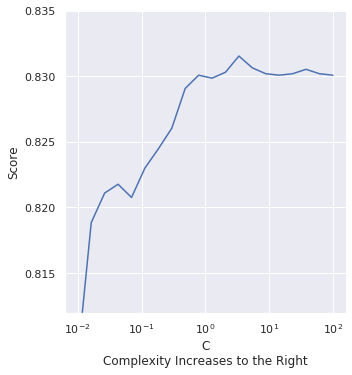

In [27]:
g = sns.relplot(x='lr__C', y='score', data=df_lr, ci=None, kind='line');

ax = g.axes[0, 0]
ax.set_xscale('log')
ax.set_ylim(.812, .835)

plt.xlabel('C\nComplexity Increases to the Right')
plt.ylabel('Score');

The above plot shows a local maxima.  There is no need to adjust the parameters for GridSearchCV.

##### Support Vector Machine

In [44]:
X, y = tt.get_Xy_v6()
cols, ct = tt.get_ct_v5()

svm = SVC(gamma='auto', probability=True)
svm_pipe_best = Pipeline([('ct', ct), ('svm', svm)])

params = {'svm__C': np.logspace(2, 4, 3),
          'svm__gamma': np.logspace(-4, -1, 4)}

grid = GridSearchCV(estimator=svm_pipe_best, param_grid=params,
                    scoring='accuracy', cv=cv_select)

# find the best hyperparameters and associated score
grid.fit(X, y);

In [45]:
df_svm = tt.print_grid(grid, pandas=True)

Best: 0.833 +/- 0.006
svm__C: 1000.0
svm__gamma: 0.001


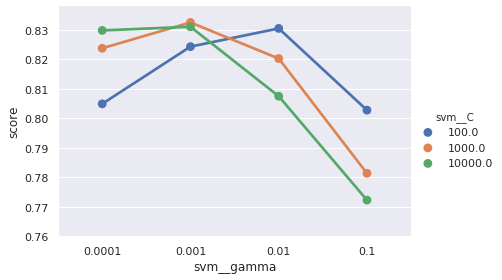

In [47]:
g = sns.catplot("svm__gamma", "score", hue="svm__C", data=df_svm,
                kind="point", height=4.0, aspect=1.5)
g.axes[0, 0].set_ylim(0.76, 0.838);

From the above plot, the local maxima for the C=10000 curve may be between gamma=.0001 and gamma=.0001.  This local maxima could be higher than that for the C=1000.0 curve.

Adjust the GridSearchCV parameters and rerun it.

In [48]:
params = {'svm__C': np.logspace(2, 4, 3),
          'svm__gamma': [.0001, .0005, .001, .01, .1]}

grid = GridSearchCV(estimator=svm_pipe_best, param_grid=params,
                    scoring='accuracy', cv=cv_select)

# find the best hyperparameters and associated score
grid.fit(X, y);

In [49]:
df_svm = tt.print_grid(grid, pandas=True)

Best: 0.834 +/- 0.007
svm__C: 10000.0
svm__gamma: 0.0005


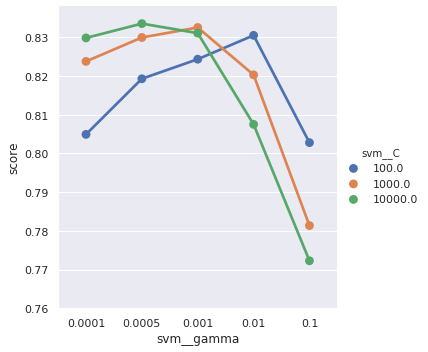

In [50]:
g = sns.catplot("svm__gamma", "score", "svm__C", data=df_svm, kind="point")
g.axes[0, 0].set_ylim(0.76, 0.838);

Although the above is splitting hairs, it shows how to manually adjust the multidimensional hyperparameter grid so as to home in on the best values.

Each of the 3 curves now shows a local maxima.  A good set of hyperparameter values have been found.

##### KNN

In [51]:
X, y = tt.get_Xy_v6()
cols, ct = tt.get_ct_v5()

knn = KNeighborsClassifier()
knn_pipe_best = Pipeline([('ct', ct), ('knn', knn)])

params = {'knn__n_neighbors': [2, 3, 5, 8, 13, 21, 34, 55, 89],
          'knn__weights': ['uniform', 'distance'],
          'knn__p':[1, 2]}

grid = GridSearchCV(estimator=knn_pipe_best, param_grid=params,
                    scoring='accuracy', cv=cv_select)

# find the best hyperparameters and associated score
grid.fit(X, y);

In [52]:
df_knn = tt.print_grid(grid, pandas=True)

Best: 0.824 +/- 0.008
knn__n_neighbors: 13
knn__p: 1
knn__weights: uniform


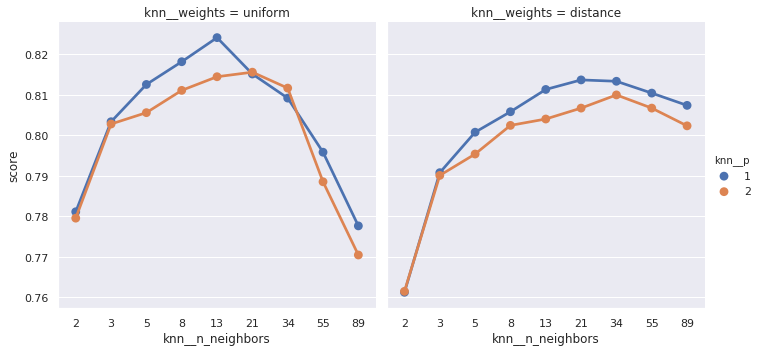

In [53]:
g = sns.catplot("knn__n_neighbors", "score", "knn__p", 
                col="knn__weights", data=df_knn, kind="point")

In the above, weights='uniform' is clearly doing better than weights='distance'.

It's probably splitting hairs, but a better local maxima could be found by fixing weights='uniform' and trying more values of n between about 10 and 15.

In [54]:
params = {'knn__n_neighbors': [10, 11, 12, 13, 14, 15],
          'knn__weights': ['uniform'],
          'knn__p':[1, 2]}

grid = GridSearchCV(estimator=knn_pipe_best, param_grid=params,
                    scoring='accuracy', cv=cv_select)

# find the best hyperparameters and associated score
grid.fit(X, y);

In [55]:
df_knn = tt.print_grid(grid, pandas=True)

Best: 0.824 +/- 0.008
knn__n_neighbors: 12
knn__p: 1
knn__weights: uniform


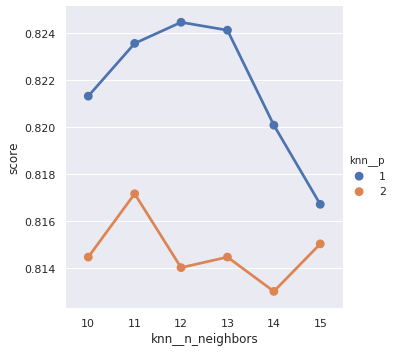

In [56]:
g = sns.catplot("knn__n_neighbors", "score", "knn__p", 
                data=df_knn, kind="point")

Minor differences in the score at this level of resolution are likely due to pure chance.  That said, the best was found at n=12 with p=1.

##### XGB

In [74]:
X, y = tt.get_Xy_v6()
cols, ct = tt.get_ct_v5()

xgb_best = XGBClassifier(objective='binary:logistic', random_state=48)

params = {'n_estimators': [100], 
          'learning_rate': [0.01, .02, .03, .04,
                            .05, .06, .07, .08],
          'max_depth': [4, 5, 6, 7, 8, 9, 10],
          'colsample_bytree': [1.0, 0.6, 0.55, 0.5, 0.45, 0.4]}
grid = GridSearchCV(estimator=xgb_best, param_grid=params,
                    scoring='accuracy', cv=cv_select)

# find the best hyperparameters and associated score
grid.fit(X, y);

In [82]:
df_xgb = tt.print_grid(grid, pandas=True)

Best: 0.833 +/- 0.007
colsample_bytree: 0.55
learning_rate: 0.03
max_depth: 9
n_estimators: 100
score: 0.8328843995510662
std: 0.014329636386614828


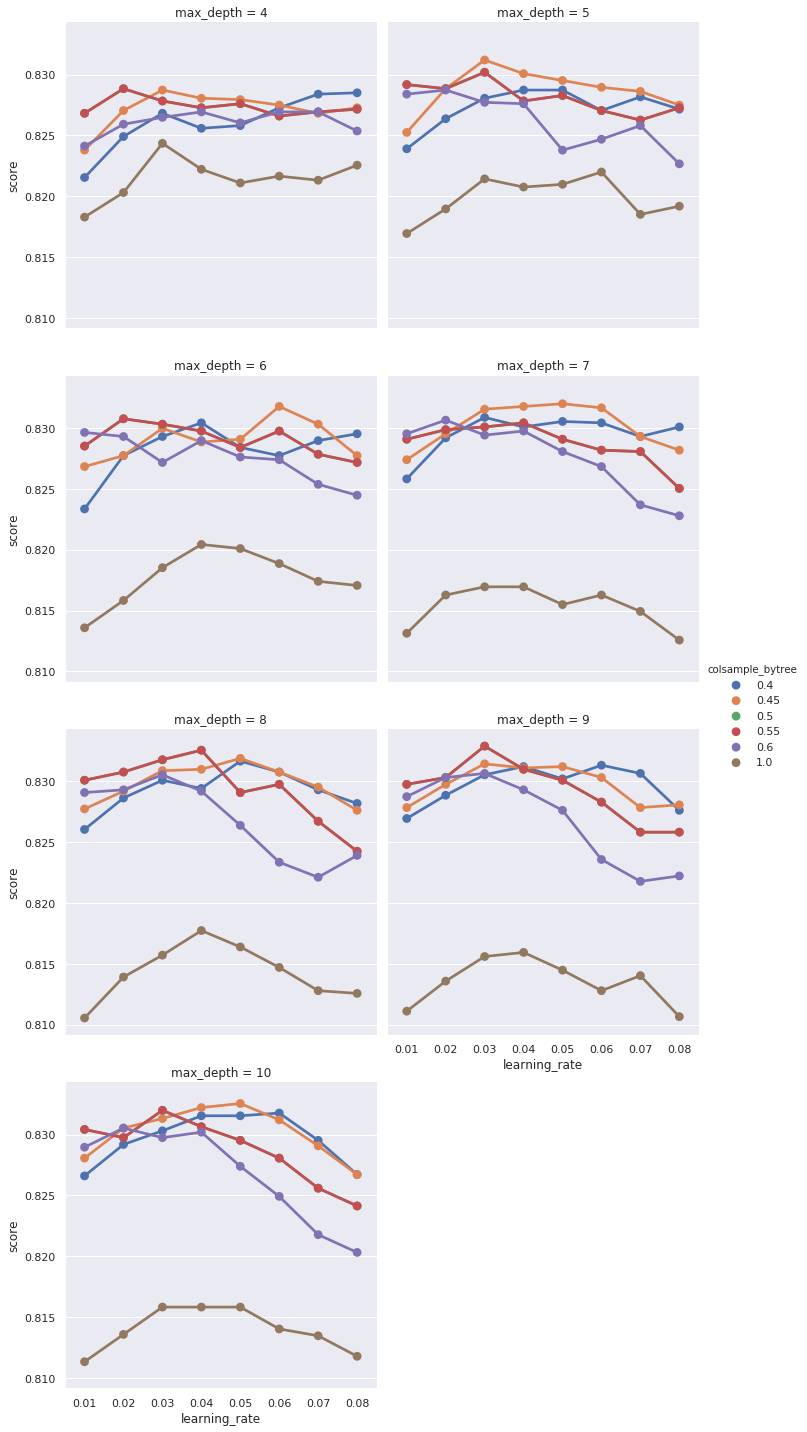

In [76]:
g = sns.catplot("learning_rate", "score", "colsample_bytree", 
                col="max_depth", col_wrap=2, 
                data=df_xgb, kind="point", ci=None)

From the above, it is likely that a local maxima exists near the values found by GridSearchCV.  Adjusting the parameters is unlikely to make much difference.

#### Neural Network
There are an infinite amount of possibilities. Keras and other packages are better.  Here, try a few with the Scikit Learn NN.

Include the default of hidden_layers = (100,) alpha = .0001

In [88]:
alpha_values = [0.05, 0.1, 0.2, 0.3, 0.4, 0.45, 0.5, 0.7, 0.8, 0.9, 1.0, 1.1]

In [89]:
X, y = tt.get_Xy_v6()
cols, ct = tt.get_ct_v5()

nn = MLPClassifier(max_iter=2000, random_state=909)
nn_pipe_best = Pipeline([('ct', ct), ('nn', nn)])

params = {'nn__hidden_layer_sizes':[(50,),(100,),(200,)],
          'nn__alpha':alpha_values}       
grid = GridSearchCV(estimator=nn_pipe_best, param_grid=params,
                    scoring='accuracy', cv=cv_select)

# find the best hyperparameters and associated score
grid.fit(X, y);

In [90]:
df_nn = tt.print_grid(grid, pandas=True)

Best: 0.832 +/- 0.008
nn__alpha: 0.5
nn__hidden_layer_sizes: (50,)


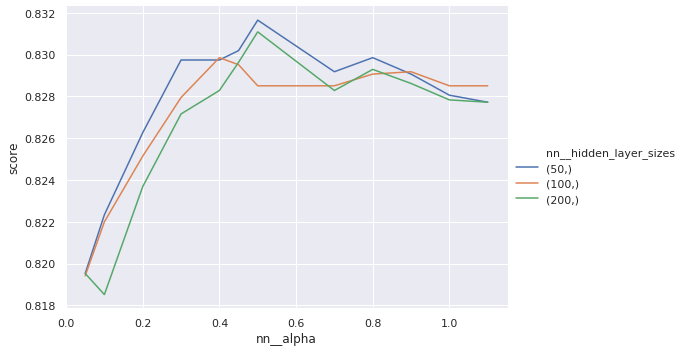

In [92]:
g = sns.relplot("nn__alpha", "score", "nn__hidden_layer_sizes",
                data=df_nn, kind="line", height=5, aspect=1.5, 
                ci=None)

The best was (50,) at alpha = 0.50.

With neural networks, or xgb or any classifier built on many individual models, it is useful to change the random_state to see how different the plot is.  Although not shown here, the above plot was similar to those which used a different random_state.

## Try Optimized Base Learners

In [93]:
idx = df_lr['score'].idxmax()
c = df_lr['lr__C'][idx]
lr_best = LogisticRegression(penalty='l2', solver='liblinear', C=c)
lr_pipe_best = Pipeline([('ct', ct), ('lr', lr_best)])

In [94]:
idx = df_svm['score'].idxmax()
gamma = df_svm['svm__gamma'][idx]
c = df_svm['svm__C'][idx]
svm_best = SVC(gamma=gamma, C=c, probability=True)
svm_pipe_best = Pipeline([('ct', ct), ('svm', svm_best)])

In [95]:
idx = df_knn['score'].idxmax()
n_neighbors = df_knn['knn__n_neighbors'][idx]
p = df_knn['knn__p'][idx]
weights = df_knn['knn__weights'][idx]
knn_best = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, p=p)
knn_pipe_best = Pipeline([('ct', ct), ('knn', knn_best)])

In [96]:
idx = df_xgb['score'].idxmax()
colsample_bytree = df_xgb['colsample_bytree'][idx]
learning_rate = df_xgb['learning_rate'][idx]
max_depth = df_xgb['max_depth'][idx]
n_estimators = df_xgb['n_estimators'][idx]
xgb_best = XGBClassifier(n_estimators=n_estimators, learning_rate=learning_rate,
                         colsample_bytree=colsample_bytree, max_depth=max_depth,
                         random_state=48)

In [97]:
idx = df_nn['score'].idxmax()
hidden_layer_sizes = df_nn['nn__hidden_layer_sizes'][idx]
alpha = df_nn['nn__alpha'][idx]

nn_best = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, alpha=alpha,
                       max_iter=2000, random_state=909)
nn_pipe_best = Pipeline([('ct', ct), ('nn', nn_best)])

In [98]:
base_learners = [lr_pipe_best, knn_pipe_best, xgb_best, svm_pipe_best, nn_pipe_best]

In [99]:
# Evaluate the Accuracy of each base learner
for base_learner in base_learners:
    if hasattr(base_learner, 'steps'):
        name = base_learner.steps[1][0].upper()
    else:
        name = base_learner.__class__.__name__
        
    scores  = cross_val_score(base_learner,  X, y, scoring='accuracy', cv=cv_select)
    print(f'{name:13} Score: {scores.mean():.3f} +/- {scores.std():.3f}')

LR            Score: 0.832 +/- 0.014
KNN           Score: 0.824 +/- 0.015
XGBClassifier Score: 0.832 +/- 0.014
SVM           Score: 0.834 +/- 0.014
NN            Score: 0.832 +/- 0.016


Scores from Default Instances  
LR            Score: 0.830 +/- 0.008  
KNN           Score: 0.807 +/- 0.007  
XGBClassifier Score: 0.820 +/- 0.008  
SVM           Score: 0.830 +/- 0.008  
NN            Score: 0.818 +/- 0.006  

In [100]:
# LR, SVM, XGB with SVM meta learner    was 832
base_learners = [lr_pipe_best, svm_pipe_best, xgb_best]
meta_learner = SVC(gamma='auto')
sc = StackedClassifier(base_learners, meta_learner, cv_predict)
scores = cross_val_score(sc, X, y, cv=cv_select)
tt.print_scores(scores)

20 Scores  min:0.813 max:0.854
CV Mean Score: 0.834 +/- 0.014


In [101]:
# LR, SVM, KNN, XGB with SVM meta learner    was 832
base_learners = [lr_pipe_best, svm_pipe_best, knn_pipe_best, xgb_best]
meta_learner = SVC(gamma='auto')
sc = StackedClassifier(base_learners, meta_learner, cv_predict)
scores = cross_val_score(sc, X, y, cv=cv_select)
tt.print_scores(scores)

20 Scores  min:0.814 max:0.857
CV Mean Score: 0.833 +/- 0.013


In [102]:
# LR, SVM, KNN, XGB, NN with SVM meta learner    was 832
base_learners = [lr_pipe_best, svm_pipe_best, knn_pipe_best, xgb_best, nn_pipe_best]
meta_learner = SVC(gamma='auto')
sc = StackedClassifier(base_learners, meta_learner, cv_predict)
scores = cross_val_score(sc, X, y, cv=cv_select)
tt.print_scores(scores)

20 Scores  min:0.813 max:0.857
CV Mean Score: 0.834 +/- 0.013


In [103]:
vc = VotingClassifier([('lr', lr_pipe_best), ('svm', svm_pipe_best),  # 833
                       ('xgb', xgb_best)], voting='hard')
scores = cross_val_score(vc, X, y, cv=cv_select)
tt.print_scores(scores)

20 Scores  min:0.818 max:0.857
CV Mean Score: 0.834 +/- 0.012


In [104]:
vc = VotingClassifier([('lr', lr_pipe_best), ('svm', svm_pipe_best),  # 833
                       ('xgb', xgb_best), ('nn', nn_pipe_best)], voting='hard')
scores = cross_val_score(vc, X, y, cv=cv_select)
tt.print_scores(scores)

20 Scores  min:0.814 max:0.863
CV Mean Score: 0.835 +/- 0.014


In [105]:
vc = VotingClassifier([('lr', lr_pipe_best), ('svm', svm_pipe_best),
                       ('xgb', xgb_best), ('nn', nn_pipe_best),
                       ('knn', knn_pipe_best)], voting='hard')
scores = cross_val_score(vc, X, y, cv=cv_select)
tt.print_scores(scores)

20 Scores  min:0.816 max:0.861
CV Mean Score: 0.835 +/- 0.013


### Tune Meta Learner
Several additional experiments were tried involving different subsets of base learners and different meta learners.  None were better than LR, SVM with SVM meta learner.

Although much tuning could be done, the most important estimator to tune is the meta learner.

To keep the custom StackingClassifier simple, it was not coded to work with GridSearchCV.

In [107]:
# This simple StackingClassifier does not support GridSearchCV
# Use nested for-loop instead
base_learners = [lr_pipe_best, svm_pipe_best, xgb_best]

results = []
for g in np.logspace(-3, 0, 4):   
    for c in np.logspace(-2, 4, 7):       
        meta_learner = SVC(gamma=g, C=c)
        sc = StackedClassifier(base_learners, meta_learner, cv_predict)
        scores = cross_val_score(sc, X, y, cv=cv_select_quick)
        results.append({'gamma': g, 'C': c, 'score': scores.mean(), 
                        'moe': scores.std()})
        print(f'gamma: {g:7.3f} C: {c:8.2f} score {scores.mean():6.4f} +/- {scores.std():6.4f}')       

results = pd.DataFrame(results)

gamma:   0.001 C:     0.01 score 0.6162 +/- 0.0004
gamma:   0.001 C:     0.10 score 0.6162 +/- 0.0004
gamma:   0.001 C:     1.00 score 0.6162 +/- 0.0004
gamma:   0.001 C:    10.00 score 0.8339 +/- 0.0105
gamma:   0.001 C:   100.00 score 0.8332 +/- 0.0091
gamma:   0.001 C:  1000.00 score 0.8323 +/- 0.0105
gamma:   0.001 C: 10000.00 score 0.8321 +/- 0.0103
gamma:   0.010 C:     0.01 score 0.6162 +/- 0.0004
gamma:   0.010 C:     0.10 score 0.6162 +/- 0.0004
gamma:   0.010 C:     1.00 score 0.8337 +/- 0.0107
gamma:   0.010 C:    10.00 score 0.8334 +/- 0.0092
gamma:   0.010 C:   100.00 score 0.8328 +/- 0.0101
gamma:   0.010 C:  1000.00 score 0.8321 +/- 0.0105
gamma:   0.010 C: 10000.00 score 0.8296 +/- 0.0106
gamma:   0.100 C:     0.01 score 0.6162 +/- 0.0004
gamma:   0.100 C:     0.10 score 0.8337 +/- 0.0107
gamma:   0.100 C:     1.00 score 0.8339 +/- 0.0098
gamma:   0.100 C:    10.00 score 0.8314 +/- 0.0105
gamma:   0.100 C:   100.00 score 0.8301 +/- 0.0103
gamma:   0.100 C:  1000.00 scor

In [108]:
results.sort_values('score',ascending=False).head()

,C,gamma,moe,score
3,10.0,0.001,0.010491,0.833900
16,1.0,0.100,0.009769,0.833898
15,0.1,0.100,0.010652,0.833676
9,1.0,0.010,0.010652,0.833676
10,10.0,0.010,0.009173,0.833449


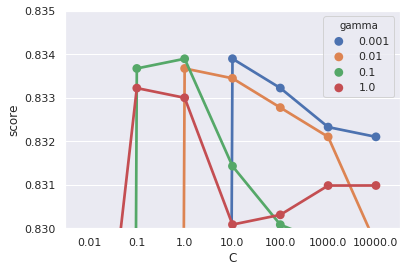

In [113]:
fig, ax = plt.subplots()
ax.set_ylim(0.830, 0.835)
sns.pointplot(x='C', y='score', hue='gamma', data=results);

# NEW Custom RF

In [7]:
from sklearn.base import TransformerMixin, BaseEstimator
class WrappedIterativeImputer(BaseEstimator, TransformerMixin):
    """Wrap IterativeImputer to return One Column Only

    The name of the column to be kept is passed to the constructor.

    This must be the first step in a pipe, as it relies on X being a Pandas DataFrame"""

    def __init__(self, return_col):
        self.ii = IterativeImputer()
        self.return_col = return_col
        self.return_col_idx = None

    def fit(self, X, y):
        self.ii.fit(X, y)
        self.return_col_idx = X.columns.get_loc(self.return_col)

        return self

    def transform(self, X):
        return_col = self.ii.transform(X)[:, self.return_col_idx]

        # must be 2D
        return return_col.reshape(-1, 1)

In [8]:
def get_ct_custom(cols):
    """Column Transform for Features

    """

    ii = WrappedIterativeImputer('Age')

    # Pipelines
    ii_pipe = Pipeline([('ii', ii)])

    # Columns to act on
    ii_cols = ['Pclass', 'Sex', 'Age', 'Title_Master',
                  'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Other']

    if 'Age' in cols:
        # cols.remove is an inplace operation
        # which operates on a reference
        cols = cols.copy()
        cols.remove('Age')
        transformers = [('ii_tr', ii_pipe, ii_cols),
                        ('as_is', 'passthrough', cols)]
        return_cols = ['Age'] + cols
    else:
        transformers = [('as_is', 'passthrough', cols)]
        return_cols = cols

    ct = ColumnTransformer(transformers=transformers)

    return return_cols, ct

In [9]:
X.columns.to_list()

['Pclass',
 'Sex',
 'Age',
 'Fare',
 'family_size',
 'is_cabin_notnull',
 'Port_C',
 'Port_Q',
 'Port_S',
 'Title_Master',
 'Title_Miss',
 'Title_Mr',
 'Title_Mrs',
 'Title_Other']

In [10]:
import itertools
subsets = []
for r in range(7,8):
    subsets.extend(list(itertools.combinations(X.columns, r=r)))

In [11]:
len(subsets)

3432

In [12]:
ss = subsets[:12]
len(ss)

12

In [13]:
from sklearn.metrics import accuracy_score, log_loss

In [38]:
from sklearn.model_selection import cross_validate

In [15]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
dtree = DecisionTreeClassifier(criterion = "entropy")

### Multi procesing
cross_val_score can be used with n_jobs=-1 however for a single decision tree, this results in too small a unit-of-work.  Each fold is parallelized.

This can be seen as the CPU meter does not show all hardware cores (4 on this machine with 4 hyperthreads) being used.  This is in part because of the setup and tear down time of the internal job pool for cross_val_score.

As 20 folds are being evaluated, submitting this to pool.map will result in a unit-of-work that is 20 times larger.  As the pool is set up once and torn down once, that overhead is also avoided.

This yields much higher throughput, as can be seen on the CPU montior.

In [16]:
from collections import namedtuple
Score = namedtuple('Score', 
                   ['acc', 'acc_std', 'logloss', 'logloss_std','vars'])
def eval_tree(s):
    cols_returned, ct = get_ct_custom(list(s))    
    dtree = DecisionTreeClassifier(random_state=707)
    pipe = Pipeline([('ct', ct), ('dtree', dtree)])
    scores = cross_validate(pipe, X, y, cv=cv_select,
                            scoring=('accuracy', 'neg_log_loss'))
    return Score(scores['test_accuracy'].mean(),
                 scores['test_accuracy'].std(),
                 scores['test_neg_log_loss'].mean(),
                 scores['test_neg_log_loss'].std(),
                 s)

In [17]:
# from tqdm import tnrange, tqdm_notebook
# from tqdm.auto import tqdm

In [31]:
import multiprocessing as mp
import tqdm
import time

# cpu_count includes hyperthreads
# pool = mp.Pool(mp.cpu_count()-1)
pool = mp.Pool(4)

start = time.time()
scores = list(tqdm.tqdm(
    pool.imap_unordered(eval_tree, subsets, chunksize=1), 
              total=len(subsets)))
stop = time.time()

100%|██████████| 3432/3432 [14:54<00:00,  9.20it/s]


In [32]:
print(f'Time: {stop-start:7.1f}')
pool.close()
pool.join()

Time:   894.9


In [33]:
# save it
scores_df = pd.DataFrame(scores)
scores_df.to_csv('data/tree_scores.csv', index=False)

### Score It

In [34]:
tree_scores = pd.read_csv('data/tree_scores.csv')
tree_scores.head()

,acc,acc_std,logloss,logloss_std,vars
0,0.771499,0.018042,-7.750423,0.656320,"('Pclass', 'Sex', 'Age', 'Fare', 'family_size'..."
1,0.768577,0.014719,-7.847498,0.505880,"('Pclass', 'Sex', 'Age', 'Fare', 'family_size'..."
2,0.769812,0.014353,-7.808523,0.516839,"('Pclass', 'Sex', 'Age', 'Fare', 'family_size'..."
3,0.764876,0.015845,-7.975553,0.546027,"('Pclass', 'Sex', 'Age', 'Fare', 'family_size'..."
4,0.772287,0.021242,-7.718990,0.755383,"('Pclass', 'Sex', 'Age', 'Fare', 'family_size'..."


In [35]:
best = scores_df.nlargest(n=len(subsets)//2, columns=['acc'])
best.shape

(1716, 5)

In [39]:
acc_trees = []
for i, s in enumerate(subsets):
    cols_returned, ct = get_ct_custom(list(s))    
    dtree = DecisionTreeClassifier(random_state=707)
    pipe = Pipeline([('ct', ct), ('dtree', dtree)])
    acc_trees.append((f'{i}', pipe))

In [40]:
# easier if trees are saved during evaluation
# otherwise must instantiate tree per subset (each row of vars)
from sklearn.ensemble import VotingClassifier

vc = VotingClassifier(acc_trees, voting='hard')
scores = cross_val_score(vc, X, y, cv=cv_select)
tt.print_scores(scores)

20 Scores  min:0.791 max:0.847
CV Mean Score: 0.826 +/- 0.014


In [41]:
# easier if trees are saved during evaluation
# otherwise must instantiate tree per subset (each row of vars)
from sklearn.ensemble import VotingClassifier

vc = VotingClassifier(acc_trees, voting='soft')
scores = cross_val_score(vc, X, y, cv=cv_select)
tt.print_scores(scores)

20 Scores  min:0.800 max:0.845
CV Mean Score: 0.823 +/- 0.013


# Summary

In the above, hyperparameter optimization was performed and evaluated without using Nested CV.  This means the above performance estimate could be a little high.  That said, .834 +/- .010 is no better than the scores from previous iterations.

The last two iterations:
* optimization of regularization
* stacking and votingclassiver with optimization of several hyperparameters  

did not produce any improvement.  It is likely this is near the best of what is possible.

It may be that better extracted features would allow for a slightly better model.

Note: on Kaggle, for this data set, some people artificially manage a high score either by resubmitting their model on the Kaggle hold-out set over and over, or by directly using the hold-out set target values which are published elsewhere.  Models which produced a score above about 0.85 probably used a technique that would not work on real-world problems.